## dataset
[] short sentenses are merge into long
[] doc packed per paragraph
[] 3 paragraphs build single sequence
[] sequence from sentences where seq_len is length of document - features include neighbors -2,-1,+1,+2 of entire document

In [32]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils, common_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import scipy
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [25]:
dir_name="scaled_stop_w"

In [26]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)

In [19]:
imp.reload(doc_utils)
doc_db =  pd.read_csv("./dataframes/doc_db.csv")
doc_db.sort_values(by='doc_idx_from_name',inplace=True)
doc_db

path              file_name  \
0   /path1   /path2   /path3   /path4   /path..                                                ...                    ...   
75  /path76  /path77  /path78  /path79  /path
    doc_idx_from_name  par_count  sent_count  nar_sent_count  
0                   1 205.000000  580.000000      256.000000  
1                   2 157.000000  632.000000       70.000000  
2                   3 118.000000  559.000000      102.000000  
3                   4 132.000000  460.000000      172.000000  
4                   5  65.000000  510.000000      270.000000  
..                ...        ...         ...             ...  
75                 76 132.000000  464.000000      164.000000  
76                 77 176.000000  406.000000       64.000000  
77                 78 122.000000  178.000000       44.000000  
78                 79 173.000000  252.000000       70.000000  
79                 80 225.000000  491.000000      102.000000  

[80 rows x 6 columns]

In [27]:
imp.reload(feature_utils)
scaled_stop_docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','char_wb','lemma'],
                                                              merged_str = 'scaled_merged'
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14918 items packed for 80 docs


In [28]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(scaled_stop_docs_map,per_par,seq_len,step)

[8] 82 -> 28 [22] 89 -> 30 [37] 99 -> 33 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [54] 243 -> 81 [41] 137 -> 46 [60] 245 -> 82 [75] 68 -> 23 [59] 370 -> 124 [66] 366 -> 122 [73] 85 -> 29 [52] 275 -> 92 [47] 160 -> 54 [78] 122 -> 41 [10] 123 -> 41 [5] 65 -> 22 [24] 158 -> 53 [31] 79 -> 27 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [61] 433 -> 145 [74] 95 -> 32 [55] 249 -> 83 [40] 148 -> 50 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [67] 407 -> 136 [72] 420 -> 140 [58] 384 -> 128 [25] 122 -> 41 [30] 82 -> 28 [11] 121 -> 41 [4] 132 -> 44 [77] 176 -> 59 [62] 248 -> 83 [48] 223 -> 75 [69] 517 -> 173 [43] 99 -> 33 [56] 268 -> 90 [1] 203 -> 68 [14] 129 -> 43 [35] 63 -> 21 [20] 90 -> 30 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [38] 90 -> 30 [7] 248 -> 83 [12] 150 -> 50 [45] 204 -> 68 [50] 184 -> 62 [71] 156 -> 52 [64] 347 -> 116 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [34] 49 

In [29]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"scaled.stop_docs_map.json")
with open(json_path, 'w') as fp:
    json.dump(scaled_stop_docs_map,fp)

In [30]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(scaled_stop_docs_map,test_percent,seq_len,step,seed)

In [34]:
%%time
# define fixed parameters and parameters to search
my_cv=model_utils.ByDocFold()
crf_scaled_stop = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_scaled_stop = RandomizedSearchCV(crf_scaled_stop, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs_scaled_stop.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
117 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 8min 37s, sys: 1min 22s, total: 10min
Wall time: 10min 21s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2ae0b67e3190>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ae0b67fc520>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ae0b67fc7f0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [35]:
# crf = rs.best_estimator_
print('best params:', rs_scaled_stop.best_params_)
print('best CV score:', rs_scaled_stop.best_score_)
print('model size: {:0.2f}M'.format(rs_scaled_stop.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.9575569718881817, 'c2': 0.17344128962163569, 'min_freq': 5}
best CV score: 0.7867377225274642
model size: 0.14M



              precision    recall  f1-score   support

      is_nar       0.74      0.61      0.67      2089
     not_nar       0.85      0.92      0.88      5227

    accuracy                           0.83      7316
   macro avg       0.80      0.76      0.78      7316
weighted avg       0.82      0.83      0.82      7316



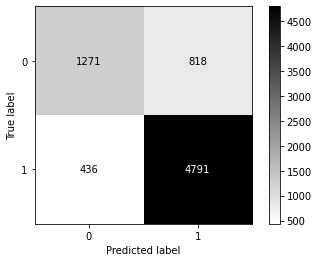

In [36]:
best_crf = rs_scaled_stop.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf_scaled_stop.classes_)

### Look at the features

In [64]:
imp.reload(model_utils)
all_features_cv = model_utils.get_features_df(dir_name,Counter(best_crf.state_features_).most_common())

In [65]:
all_features_cv.describe()

,weight
count,10532.000000
mean,0.025757
std,0.185030
min,-1.491894
25%,-0.000057
50%,0.000001
75%,0.001799
max,2.312541


In [66]:
all_features_cv[all_features_cv['label']=='is_nar'].head(30)

,weight,label,attr,string
1,2.079952,is_nar,tfidf_word_25938,תקשיבי
2,2.047576,is_nar,tfidf_lemma_926,ארגן
3,2.046267,is_nar,tfidf_lemma_505,איכל
4,1.997642,is_nar,tfidf_lemma_4385,יישב
5,1.894588,is_nar,tfidf_lemma_9204,שיר
6,1.869153,is_nar,tfidf_word_23910,שלח
9,1.661181,is_nar,tfidf_word_22274,שאל
10,1.633130,is_nar,tfidf_lemma_1533,גוגל
18,1.491894,is_nar,tfidf_char_wb_413,אמר
20,1.454677,is_nar,tfidf_lemma_9028,שוטר


In [67]:
all_features_cv[all_features_cv['attr'].str.contains('idx')]

,weight,label,attr,string
1468,0.028631,is_nar,sent_idx_in_par,
1499,0.026161,not_nar,+2:sent_idx_in_par,
1765,0.013938,is_nar,+1:sent_idx_in_par,
2178,0.006437,not_nar,-1:sent_idx_in_par,
2626,0.001821,not_nar,-2:sent_idx_in_par,
2947,0.000770,not_nar,par_idx_in_doc,
3149,0.000460,not_nar,sent_idx,
3263,0.000350,is_nar,+2:par_idx_in_doc,
3361,0.000276,is_nar,-1:par_idx_in_doc,
3424,0.000229,is_nar,-2:par_idx_in_doc,


In [68]:
all_features_cv[all_features_cv['attr'].str.contains('tense')]

,weight,label,attr,string
409,0.359149,is_nar,f_tense_PAST,
480,0.299412,is_nar,-1:f_tense_PAST,
512,0.277776,is_nar,+1:f_tense_PAST,
521,0.274479,is_nar,-2:f_tense_PAST,
574,0.243155,is_nar,+2:f_tense_PAST,
1056,0.072658,not_nar,f_tense_FUTURE,
1181,0.054359,not_nar,-1:f_tense_IMPERATIVE,
1239,0.046593,not_nar,-2:f_tense_IMPERATIVE,
1340,0.037275,not_nar,f_tense_IMPERATIVE,
1405,0.032611,not_nar,+2:f_tense_IMPERATIVE,


In [69]:
all_features_cv[~all_features_cv['attr'].str.contains('tf')]

,weight,label,attr,string
123,0.829755,not_nar,-1:f_suf_gen_F,
264,0.529774,not_nar,f_suf_gen_F,
265,0.528853,not_nar,-1:f_per_2,
346,0.418242,not_nar,f_per_2,
409,0.359149,is_nar,f_tense_PAST,
...,...,...,...,...
10395,-0.359149,not_nar,f_tense_PAST,
10425,-0.418242,is_nar,f_per_2,
10462,-0.528853,is_nar,-1:f_per_2,
10463,-0.529774,is_nar,f_suf_gen_F,


### Save all features db

In [70]:
f_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"crf_features.csv")
all_features_cv.to_csv(f_path,index=False)

## Feature selection based on weight

<AxesSubplot:ylabel='Frequency'>

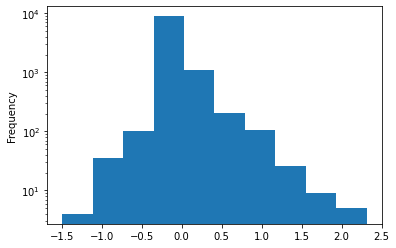

In [71]:
all_features_cv['weight'].plot(kind='hist',logy=True)

In [72]:
q = all_features_cv['weight'].quantile(q=[0.1, 0.9])
q

0.100000   -0.012706
0.900000    0.073464
Name: weight, dtype: float64

In [339]:
q.iloc[0],q.iloc[1]

(-0.022233799999999998, 0.096775)